In [2]:
import os, sys
import pandas as pd
import yfinance as yf
from datetime import datetime

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, leaves_list
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 300) # specifies number of rows to show
#pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline


In [3]:
# reead the list of S&P 500 Companies as of September 2021

file_path = "company_list_aft2018.csv"  # Replace with your CSV file path
df = pd.read_csv(file_path)

#  rename symbol column to company and stores the info in a new df
sp500_tickers = df.rename(columns={"symbol": "company"})
sp500_tickers.head()

,Unnamed: 0,company
0,0,MMM
1,1,AOS
2,2,ABT
3,3,ABBV
4,4,ACN


In [4]:
# NOTE 1: Run this only once to fetch all tickers from yfinace and commment back after(read next note in comment)
# NOTE 2: create a new directory call "s&p500_data" in current working directory BEFORE running this cell
# NOTE 3: This will take a while to run, so be patient
"""
# Loop through each company symbol in the 'company' column to download historical data form all S&P500 companies from 01.01.2018 to 12.31.2022

# mark start and end dates
start_date = datetime(2018, 1, 1)
end_date = datetime(2022, 12, 31)

# Download historical data for all S&P 500 companies
for ticker in sp500_tickers['company']:
    print(f"Downloading data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    data.to_csv(f"SP500_data/{ticker}.csv")
    print(f"Data saved for {ticker}")
"""

'\n# Loop through each company symbol in the \'company\' column to download historical data form all S&P500 companies from 01.01.2018 to 12.31.2022\n\n# mark start and end dates\nstart_date = datetime(2018, 1, 1)\nend_date = datetime(2022, 12, 31)\n\n# Download historical data for all S&P 500 companies\nfor ticker in sp500_tickers[\'company\']:\n    print(f"Downloading data for {ticker}...")\n    data = yf.download(ticker, start=start_date, end=end_date)\n    data.to_csv(f"s&p500_data/{ticker}.csv")\n    print(f"Data saved for {ticker}")\n'

In [5]:
# read  a sample s&p500 ticker from s&p500_data dir for easy processing  
ticker_A = pd.read_csv('SP500_data/A.csv')
ticker_A.head(10) # NOTE: column names look good so no need to rename


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,67.419998,67.889999,67.339996,67.599998,64.989273,1047800
1,2018-01-03,67.620003,69.489998,67.599998,69.320000,66.642830,1698900
2,2018-01-04,69.540001,69.820000,68.779999,68.800003,66.142906,2230700
3,2018-01-05,68.730003,70.099998,68.730003,69.900002,67.200439,1632500
4,2018-01-08,69.730003,70.330002,69.550003,70.050003,67.344643,1613400
5,2018-01-09,70.680000,72.330002,70.169998,71.769997,68.998222,2666100
6,2018-01-10,71.449997,71.449997,70.110001,70.790001,68.056046,2957200
7,2018-01-11,70.919998,71.180000,70.300003,70.800003,68.065697,1511100
8,2018-01-12,70.730003,71.860001,70.500000,71.730003,68.959740,1448100
9,2018-01-16,72.019997,72.470001,71.059998,71.230003,68.479057,1702700


In [6]:
# visualiza  the data types of each column in the DataFrame ticker A.
ticker_A.dtypes


Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
# to convert the columns of a pandas DataFrame to specific data types.
# In particular, convert the "Date" column to and actual "Datetime" instance 
ticker_A.Date = pd.to_datetime(ticker_A.Date)
ticker_A.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [8]:
# mark start and end dates
start_date = datetime(2018, 1, 1)
end_date = datetime(2022, 12, 31)

#. 1  create a boolean Series last_three_yrs, which has True values for rows where the date
#     is greater than or equal to '2018-01-01' and False values for other rows.
last_four_yrs = ticker_A['Date'] >= start_date 

# 2. filter the original DataFrame and create new dF contaiINING s only the rows with dates greater than or equal to start_date
ticker_A_new = ticker_A.loc[last_four_yrs]

# 3.drop the 2nd, 3rd, and 4th columns (at indices 1, 2, and 3) of ticker_A_new
ticker_A_new.drop(ticker_A_new.columns[[1,2,3]], axis=1, inplace=True)

# 4. set the index of df_new to the date column. The inplace=True.
ticker_A_new.set_index('Date', inplace=True)

# 5. calculates the daily price return and stores the result in a new column named Price_Return.
#    The .shift() function is used to shift the "Close"  column down by one row, so that the calculation
#    represents the percentage change between the current row's closing price and the previous row's closing price.
ticker_A_new['Price_Return'] = ticker_A_new['Adj Close']/ticker_A_new['Adj Close'].shift()-1

# 6. replace any NaN values in the Price_return column with 0. 
#    This can occur in the first row of the DataFrame, where there is no previous closing price available for the calculation.

ticker_A_new['Price_Return'].fillna(0, inplace=True)

ticker_A_new.head(10)

,Close,Adj Close,Volume,Price_Return
Date,,,,
2018-01-02,67.599998,64.989273,1047800,0.000000
2018-01-03,69.320000,66.642830,1698900,0.025444
2018-01-04,68.800003,66.142906,2230700,-0.007502
2018-01-05,69.900002,67.200439,1632500,0.015989
2018-01-08,70.050003,67.344643,1613400,0.002146
2018-01-09,71.769997,68.998222,2666100,0.024554
2018-01-10,70.790001,68.056046,2957200,-0.013655
2018-01-11,70.800003,68.065697,1511100,0.000142
2018-01-12,71.730003,68.959740,1448100,0.013135


# Creating Stock Correlation Matrices for  Network Analysis

In [9]:
# Define a function read_csv_files(root) that loops through all CSV files in a specified directory
#  (except for 's&p500.csv' and 'SPX.csv'), reads their content into pandas DataFrames, and stores them
# in a dictionary with the file names (without the extension) as keys.

root = "s&p500_data/"

def read_csv_files(root):
    
    '''Loop through each csv file in directory and store them in a dictionary'''
    
    stock_dict = {}

    for file in os.listdir(root):
        if (file == 's&p500.csv') or (file == 'SPX.csv') :
            continue
        
        elif file.endswith(".csv"):
            name = os.path.splitext(file)[0]
            stock_dict[name] = pd.read_csv(os.path.join(root, file))
    
    return stock_dict

# Implementation
stock_dict = read_csv_files(root)

len(stock_dict)

501

In [10]:
import numpy as np
# define another function "build_tables_of_stocks(stock_dict)"" that takes a dictionary of stock data as an input and constructs five DataFrames
# for each stock: daily closing prices, daily trading volumes, daily price returns, daily log returns, and daily market capitalizations.

def build_tables_of_stocks(stock_dict):
    
    '''Constructs dataframes of daily closing prices, daily trading volumes, daily price returns and 
    daily log returns for each stock over the last 3 years'''
    
    # 1. Initialize five empty DataFrames
    df_price, df_volume, df_return, df_logret, df_marketcap = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    # 2. Loop through each file in stock_dict
    for file in stock_dict: 
        # For each stock, perform the following steps:
        df1 = pd.DataFrame(stock_dict[file])
        #print(df1.head())
        #print("\n")
    
        name_price = str(file).split('.')[0] + " Close" 
        name_volume = str(file).split('.')[0] + " Volume" 
        name_return = str(file).split('.')[0] + " Price_Return" 
        name_logret = str(file).split('.')[0] + " Log_Return"
        name_marketcap = str(file).split('.')[0] + " Market_Cap" 
        
        # NOTE: We use "Adj Close" not "Close" to calculate the market cap, as the former accounts for any 
        # corporate actions such as dividends, stock splits, or new stock offerings that could have occurred 
        # during the stock's trading history
        
        # calculate the market cap, price return, and log return for each stock.
        df1.iloc[:,1:] = df1.iloc[:,1:].astype(float)
        df1[name_marketcap] = df1['Adj Close'] * df1['Volume']
        df1[name_return] = df1['Adj Close']/df1['Adj Close'].shift()-1
        df1[name_return] = df1[name_return].astype(float)
        df1[name_logret] = np.log(df1[name_return]+1)
        df1[name_return].fillna(0, inplace=True)
        df1[name_logret].fillna(0, inplace=True)

        df1 = df1.rename(columns={ 'Adj Close': name_price,'Volume': name_volume})
        df1.Date = pd.to_datetime(df1.Date)
           
        last_four_yrs = df1['Date'] >= start_date #'2008-03-03'
        df1 = df1.loc[last_four_yrs]
        df1.drop(columns=['Open', 'High','Low'], inplace=True)
        df1.set_index('Date', inplace=True)
        df1.iloc[:,:] = df1.iloc[:,:].astype(float)
         
        # Add the relevant columns from the current stock DataFrame to the five aggregated
        df_price[name_price.split(' ')[0]] = df1[name_price]
        df_volume[name_volume.split(' ')[0]] = df1[name_volume]
        df_return[name_return.split(' ')[0]] = df1[name_return]
        df_logret[name_logret.split(' ')[0]] = df1[name_logret]
        df_marketcap[name_marketcap.split(' ')[0]] = df1[name_marketcap]
        
    
    return df_price, df_volume, df_return, df_logret, df_marketcap

# Implementation
closing_price, trading_volume, price_return, log_return, market_cap = build_tables_of_stocks(stock_dict)



/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/3877708222.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_price[name_price.split(' ')[0]] = df1[name_price]
/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/3877708222.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_volume[name_volume.split(' ')[0]] = df1[name_volume]
/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/3877708222.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of c

In [11]:
# Inspect dataframe
closing_price.head(10)

,CSCO,UAL,TROW,ISRG,NVR,TPR,DVN,CE,MRO,BA,...,DOV,CRM,PGR,WAT,IEX,BWA,LRCX,NWL,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,32.888611,68.940002,86.688499,125.083336,3529.610107,39.192406,33.283974,94.641350,16.268349,282.886444,...,74.973259,104.410004,46.768967,195.690002,123.875786,47.448452,173.664322,24.568645,444.689728,23.497730
2018-01-03,33.150970,68.489998,87.874283,127.940002,3562.830078,39.201061,33.670162,95.013687,16.539804,283.801270,...,75.577827,105.290001,46.743633,197.770004,124.995239,47.686703,176.618683,24.716173,449.381592,23.551485
2018-01-04,33.244762,69.260002,88.563873,125.639999,3520.510010,39.140450,34.072121,95.066879,16.961021,282.724396,...,76.012833,106.680000,46.735180,199.660004,126.999031,49.235321,177.426071,24.894772,455.314056,23.612919
2018-01-05,33.705196,69.360001,90.178581,126.336670,3567.000000,39.322300,33.977543,95.962219,16.745726,294.322266,...,75.481987,108.099998,46.912590,202.229996,126.754448,50.664837,180.196930,24.832653,459.193298,23.766495
2018-01-08,34.054771,68.510002,92.407173,130.619995,3624.800049,39.218380,34.087879,96.387749,16.820614,295.570709,...,75.526222,108.860001,47.056202,204.759995,126.970787,50.692310,181.554825,24.910303,462.618164,24.112051
2018-01-09,33.841610,68.480003,93.979836,132.533340,3625.000000,39.270344,33.528294,96.166145,16.895496,303.461548,...,76.713242,109.150002,47.453262,208.960007,127.713966,51.077179,181.270447,24.778296,466.506226,24.058294
2018-01-10,34.029202,73.080002,94.417122,141.253326,3515.850098,39.166431,33.244553,95.891304,16.755087,305.205475,...,75.717903,108.800003,47.039322,207.320007,126.942581,49.950085,175.848007,24.188150,464.435547,23.728100
2018-01-11,34.191204,76.449997,95.081512,140.456665,3550.889893,39.417549,33.946014,98.639404,17.410320,312.696014,...,76.315102,109.099998,47.022415,207.729996,128.989594,51.232964,173.517548,24.778296,469.983521,23.712742
2018-01-12,34.847736,78.400002,97.007355,139.679993,3558.229980,39.642696,34.710533,98.701485,17.616245,320.405701,...,76.779587,110.239998,47.258965,209.750000,129.055618,52.442535,172.957855,25.050068,485.369507,23.866323


In [12]:
# Inspect dataframe
trading_volume.head(10)

,CSCO,UAL,TROW,ISRG,NVR,TPR,DVN,CE,MRO,BA,...,DOV,CRM,PGR,WAT,IEX,BWA,LRCX,NWL,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,20135700.0,3390600.0,1603500.0,2483700.0,52900.0,1884300.0,4782500.0,669000.0,8107000.0,2978900.0,...,1044624.0,4669200.0,2715500.0,355300.0,441900.0,1186900.0,2037300.0,4264400.0,526400.0,6045400.0
2018-01-03,29536000.0,4590900.0,1169800.0,2365500.0,27000.0,2180500.0,3908700.0,558200.0,10684700.0,3211200.0,...,1058119.0,3888700.0,3247300.0,271700.0,376600.0,1182300.0,2583300.0,6211000.0,448700.0,8222600.0
2018-01-04,20731400.0,3922900.0,773500.0,2696400.0,34100.0,1946200.0,4243500.0,671700.0,14052100.0,4171700.0,...,1217449.0,4540200.0,2573300.0,337400.0,391300.0,1694200.0,2227200.0,3833000.0,389800.0,8392500.0
2018-01-05,24588200.0,2675900.0,1073300.0,2098500.0,19300.0,1727000.0,3722200.0,482600.0,11962200.0,6177700.0,...,1448831.0,3368400.0,3264800.0,363300.0,170600.0,2202100.0,1713000.0,3471500.0,483000.0,7203000.0
2018-01-08,16582000.0,4277900.0,1675600.0,2977500.0,35900.0,1935500.0,3596000.0,456300.0,7096800.0,4124900.0,...,1169786.0,2933600.0,3075600.0,483100.0,268200.0,1868700.0,2762700.0,2977200.0,561500.0,8892300.0
2018-01-09,21449800.0,3057000.0,1332500.0,4203300.0,16600.0,2220000.0,5826100.0,368400.0,12120500.0,5641300.0,...,1111105.0,3302300.0,3823600.0,532200.0,239000.0,1444700.0,2955000.0,5118100.0,547700.0,7025900.0
2018-01-10,19473000.0,9380400.0,1044100.0,6130800.0,27500.0,2018600.0,3457100.0,434000.0,7921900.0,4479300.0,...,846421.0,3113300.0,3212700.0,308000.0,264000.0,1196400.0,3510800.0,5102800.0,483800.0,6592200.0
2018-01-11,21685600.0,6913400.0,1956900.0,3824400.0,33200.0,1415600.0,6856900.0,552000.0,13189700.0,4635300.0,...,943480.0,3668100.0,2087100.0,202800.0,176500.0,1191500.0,2816400.0,3356900.0,765200.0,5507100.0
2018-01-12,23770500.0,4479300.0,1361100.0,2797200.0,41100.0,2325400.0,7671400.0,452600.0,10312200.0,6559300.0,...,585450.0,5749500.0,2659800.0,253000.0,159800.0,2347000.0,2788100.0,3519200.0,941800.0,6844200.0


In [13]:
# Inspect dataframe
price_return.head()

,CSCO,UAL,TROW,ISRG,NVR,TPR,DVN,CE,MRO,BA,...,DOV,CRM,PGR,WAT,IEX,BWA,LRCX,NWL,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,0.007977,-0.006527,0.013679,0.022838,0.009412,0.000221,0.011603,0.003934,0.016686,0.003234,...,0.008064,0.008428,-0.000542,0.010629,0.009037,0.005021,0.017012,0.006005,0.010551,0.002288
2018-01-04,0.002829,0.011243,0.007847,-0.017977,-0.011878,-0.001546,0.011938,0.000560,0.025467,-0.003794,...,0.005756,0.013202,-0.000181,0.009557,0.016031,0.032475,0.004571,0.007226,0.013201,0.002608
2018-01-05,0.013850,0.001444,0.018232,0.005545,0.013205,0.004646,-0.002776,0.009418,-0.012694,0.041022,...,-0.006984,0.013311,0.003796,0.012872,-0.001926,0.029034,0.015617,-0.002495,0.008520,0.006504
2018-01-08,0.010372,-0.012255,0.024713,0.033904,0.016204,-0.002643,0.003247,0.004434,0.004472,0.004242,...,0.000586,0.007031,0.003061,0.012511,0.001707,0.000542,0.007536,0.003127,0.007458,0.014540


In [14]:
# Inspect dataframe
log_return.head(10)

,CSCO,UAL,TROW,ISRG,NVR,TPR,DVN,CE,MRO,BA,...,DOV,CRM,PGR,WAT,IEX,BWA,LRCX,NWL,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,0.007946,-0.006549,0.013586,0.022581,0.009368,0.000221,0.011536,0.003926,0.016548,0.003229,...,0.008031,0.008393,-0.000542,0.010573,0.008996,0.005009,0.016869,0.005987,0.010496,0.002285
2018-01-04,0.002825,0.011180,0.007817,-0.018141,-0.011949,-0.001547,0.011867,0.000560,0.025148,-0.003802,...,0.005739,0.013115,-0.000181,0.009511,0.015904,0.031959,0.004561,0.007200,0.013115,0.002605
2018-01-05,0.013755,0.001443,0.018068,0.005530,0.013119,0.004635,-0.002780,0.009374,-0.012775,0.040203,...,-0.007008,0.013223,0.003789,0.012790,-0.001928,0.028621,0.015496,-0.002498,0.008484,0.006483
2018-01-08,0.010318,-0.012331,0.024413,0.033342,0.016074,-0.002646,0.003242,0.004425,0.004462,0.004233,...,0.000586,0.007006,0.003057,0.012433,0.001705,0.000542,0.007507,0.003122,0.007431,0.014435
2018-01-09,-0.006279,-0.000438,0.016876,0.014542,0.000055,0.001324,-0.016552,-0.002302,0.004442,0.026347,...,0.015594,0.002660,0.008403,0.020304,0.005836,0.007564,-0.001568,-0.005313,0.008369,-0.002232
2018-01-10,0.005528,0.065013,0.004642,0.063721,-0.030573,-0.002650,-0.008499,-0.002862,-0.008345,0.005730,...,-0.013060,-0.003212,-0.008761,-0.007879,-0.006058,-0.022314,-0.030370,-0.024105,-0.004449,-0.013820
2018-01-11,0.004749,0.045082,0.007012,-0.005656,0.009917,0.006391,0.020881,0.028256,0.038361,0.024246,...,0.007856,0.002754,-0.000359,0.001976,0.015997,0.025359,-0.013341,0.024105,0.011875,-0.000647
2018-01-12,0.019020,0.025187,0.020052,-0.005545,0.002065,0.005696,0.022272,0.000629,0.011758,0.024356,...,0.006068,0.010395,0.005018,0.009677,0.000512,0.023335,-0.003231,0.010908,0.032213,0.006456


In [15]:
# Inspect dataframe
market_cap.head(10)

,CSCO,UAL,TROW,ISRG,NVR,TPR,DVN,CE,MRO,BA,...,DOV,CRM,PGR,WAT,IEX,BWA,LRCX,NWL,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,6.622352e+08,2.337480e+08,1.390050e+08,3.106695e+08,1.867164e+08,7.385025e+07,1.591806e+08,6.331506e+07,1.318875e+08,8.426904e+08,...,7.831887e+07,4.875112e+08,1.270011e+08,6.952866e+07,5.474071e+07,5.631657e+07,3.538063e+08,1.047705e+08,2.340847e+08,1.420532e+08
2018-01-03,9.791471e+08,3.144307e+08,1.027953e+08,3.026421e+08,9.619641e+07,8.547791e+07,1.316066e+08,5.303664e+07,1.767228e+08,9.113426e+08,...,7.997034e+07,4.094412e+08,1.517906e+08,5.373411e+07,4.707321e+07,5.637999e+07,4.562590e+08,1.535122e+08,2.016375e+08,1.936544e+08
2018-01-04,6.892105e+08,2.717001e+08,6.850416e+07,3.387757e+08,1.200494e+08,7.617514e+07,1.445850e+08,6.385642e+07,2.383380e+08,1.179441e+09,...,9.254175e+07,4.843485e+08,1.202636e+08,6.736529e+07,4.969472e+07,8.341448e+07,3.951633e+08,9.542166e+07,1.774814e+08,1.981714e+08
2018-01-05,8.287501e+08,1.856004e+08,9.678867e+07,2.651175e+08,6.884310e+07,6.790961e+07,1.264712e+08,4.631137e+07,2.003157e+08,1.818235e+09,...,1.093606e+08,3.641240e+08,1.531602e+08,7.347016e+07,2.162431e+07,1.115690e+08,3.086773e+08,8.620656e+07,2.217904e+08,1.711901e+08
2018-01-08,5.646962e+08,2.930789e+08,1.548375e+08,3.889210e+08,1.301303e+08,7.590717e+07,1.225800e+08,4.398173e+07,1.193725e+08,1.219200e+09,...,8.834952e+07,3.193517e+08,1.447261e+08,9.891955e+07,3.405357e+07,9.472872e+07,5.015815e+08,7.416295e+07,2.597601e+08,2.144116e+08
2018-01-09,7.258958e+08,2.093434e+08,1.252281e+08,5.570774e+08,6.017500e+07,8.718016e+07,1.953392e+08,3.542761e+07,2.047819e+08,1.711918e+09,...,8.523647e+07,3.604461e+08,1.814423e+08,1.112085e+08,3.052364e+07,7.379120e+07,5.356542e+08,1.268178e+08,2.555055e+08,1.690312e+08
2018-01-10,6.626506e+08,6.855196e+08,9.858092e+07,8.659959e+08,9.668588e+07,7.906136e+07,1.149297e+08,4.161683e+07,1.327321e+08,1.367107e+09,...,6.408922e+07,3.387270e+08,1.511232e+08,6.385456e+07,3.351284e+07,5.976028e+07,6.173672e+08,1.234273e+08,2.246939e+08,1.564204e+08
2018-01-11,7.414568e+08,5.285294e+08,1.860650e+08,5.371625e+08,1.178895e+08,5.579948e+07,2.327644e+08,5.444895e+07,2.296369e+08,1.449440e+09,...,7.200177e+07,4.001897e+08,9.814048e+07,4.212764e+07,2.276666e+07,6.104408e+07,4.886948e+08,8.317826e+07,3.596314e+08,1.305884e+08
2018-01-12,8.283481e+08,3.511771e+08,1.320367e+08,3.907129e+08,1.462433e+08,9.218513e+07,2.662784e+08,4.467229e+07,1.816622e+08,2.101637e+09,...,4.495061e+07,6.338249e+08,1.256994e+08,5.306675e+07,2.062309e+07,1.230826e+08,4.822238e+08,8.815620e+07,4.571210e+08,1.633459e+08


In [16]:
# Tickers from the same company with two share classes

dual_shares_1 = ['FOX', 'GOOG', 'NWS'] 
dual_shares_2 = ['FOXA', 'GOOGL', 'NWSA']

def drop_duplicates(df, lst1, lst2):
    
    '''Adds a new column with the mean value of both share classes for 
    each day and deletes the separate ticker columns'''
    
    for name in df.columns:
        for i in range(len(dual_shares_1)):
            if name == dual_shares_1[i]:
                new_name = dual_shares_1[i] + '/' + dual_shares_2[i]
                share_1, share_2 = dual_shares_1[i], dual_shares_2[i] 
                df[new_name] = df[[share_1, share_2]].mean(axis=1)
                df.drop(columns=[share_1, share_2], inplace=True)
                
    df = df.reindex(sorted(df.columns), axis=1)
    
    return df

# Implement for closing price, trading volume, price return, log return
closing_price_500 = drop_duplicates(closing_price, dual_shares_1, dual_shares_2)
trading_volume_500 = drop_duplicates(trading_volume, dual_shares_1, dual_shares_2)
price_return_500 = drop_duplicates(price_return, dual_shares_1, dual_shares_2)
log_return_500 = drop_duplicates(log_return, dual_shares_1, dual_shares_2)
market_cap_500 = drop_duplicates(log_return, dual_shares_1, dual_shares_2)

len(closing_price_500.columns), len(trading_volume_500.columns), len(price_return_500.columns), 
len(log_return_500.columns), len(market_cap_500.columns)

/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/1614830559.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_name] = df[[share_1, share_2]].mean(axis=1)
/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/1614830559.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_name] = df[[share_1, share_2]].mean(axis=1)
/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/1614830559.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

(498, 498)

In [17]:
def split_data_by_quarters(hist_data_daily, start_year, end_year):
    quarter_splits = {}
    quarters = ['Q1', 'Q2', 'Q3', 'Q4']
    date_ranges = [
        ('01-01', '03-31'),
        ('04-01', '06-30'),
        ('07-01', '09-30'),
        ('10-01', '12-31')
    ]

    for year in range(start_year, end_year + 1):
        for i, quarter in enumerate(quarters):
            start_date, end_date = date_ranges[i]
            quarter_key = f"{year}_{quarter}"
            quarter_data = hist_data_daily.loc[hist_data_daily.index.to_series().between(f"{year}-{start_date}", f"{year}-{end_date}", inclusive="both")]
            quarter_splits[quarter_key] = quarter_data

    return quarter_splits

# Implement for closing price, trading volume, price return, log return (split the data from 2018 to 2022)
start_year = 2018
end_year = 2022
price_quarter_splits = split_data_by_quarters(closing_price_500, start_year, end_year)
volume_quarter_splits = split_data_by_quarters(trading_volume_500, start_year, end_year)
return_quarter_splits = split_data_by_quarters(price_return_500, start_year, end_year)
logret_quarter_splits = split_data_by_quarters(log_return_500, start_year, end_year)
marketcap_quarter_splits = split_data_by_quarters(market_cap_500, start_year, end_year)

# Access the data for a specific quarter
price_2018_q1 = price_quarter_splits['2018_Q1']
print(price_2018_q1)

                    A        AAL         AAP       AAPL       ABBV        ABC   
Date                                                                            
2018-01-02  64.989273  51.647560   98.501457  40.888073  76.580696  86.405479  \
2018-01-03  66.642830  51.014030   99.392776  40.880951  77.779076  86.727058   
2018-01-04  66.142906  51.335667  103.060249  41.070839  77.335495  86.534103   
2018-01-05  67.200439  51.316177  104.155846  41.538441  78.681747  87.581573   
2018-01-08  67.344643  50.809345  103.422363  41.384148  77.421127  89.033295   
2018-01-09  68.998222  50.760616  102.586723  41.379410  78.004753  89.602959   
2018-01-10  68.056046  52.417545  102.679573  41.369907  77.576752  89.318146   
2018-01-11  68.065697  54.990665  104.870773  41.604904  77.804031  90.172630   
2018-01-12  68.959740  56.988728  107.646881  42.034523  78.642662  90.962807   
2018-01-16  68.479057  56.511143  105.752815  41.820900  80.327766  91.468163   
2018-01-17  69.277000  56.68

In [18]:
def count_stocks_in_index(data_splits):
    
    '''Counts the number of stocks in the dataset that are listed or unlisted at the beginning of each year'''
    
    listed_stocks = pd.DataFrame()
    
    for key in data_splits.keys():
        df = data_splits[key]
        counts = df.isnull().any().value_counts()
        listed_stocks.loc['listed', key] = counts.get(False, 0)
        listed_stocks.loc['unlisted', key] = counts.get(True, 0)
        listed_stocks.loc['percentage (%)', key] = (listed_stocks.loc['listed', key] / (listed_stocks.loc['listed', key] + listed_stocks.loc['unlisted', key])) * 100

    return listed_stocks

listed_stocks = count_stocks_in_index(logret_quarter_splits)
listed_stocks

,2018_Q1,2018_Q2,2018_Q3,2018_Q4,2019_Q1,2019_Q2,2019_Q3,2019_Q4,2020_Q1,2020_Q2,2020_Q3,2020_Q4,2021_Q1,2021_Q2,2021_Q3,2021_Q4,2022_Q1,2022_Q2,2022_Q3,2022_Q4
listed,488.000000,488.000000,489.000000,489.000000,490.000000,492.000000,493.000000,493.000000,493.000000,495.00000,495.00000,495.00000,495.00000,495.00000,496.000000,496.000000,496.000000,497.000000,497.000000,497.000000
unlisted,10.000000,10.000000,9.000000,9.000000,8.000000,6.000000,5.000000,5.000000,5.000000,3.00000,3.00000,3.00000,3.00000,3.00000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
percentage (%),97.991968,97.991968,98.192771,98.192771,98.393574,98.795181,98.995984,98.995984,98.995984,99.39759,99.39759,99.39759,99.39759,99.39759,99.598394,99.598394,99.598394,99.799197,99.799197,99.799197


# Inspecting Correlation Matrices

In [19]:
# Inspect correlation matrix for whole log return dataframe
corr_log_return = log_return_500.corr()

corr_log_return.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.322244,0.376572,0.574751,0.410922,0.402150,0.640381,0.467983,0.652941,0.609272,...,0.374200,0.366551,0.363629,0.393937,0.590016,0.452745,0.480052,0.559995,0.402938,0.648468
AAL,0.322244,1.000000,0.338396,0.326680,0.181459,0.258958,0.232454,0.442994,0.374904,0.252089,...,0.537490,0.119605,0.410002,0.343069,0.465241,0.407123,0.443941,0.353051,0.525097,0.263334
AAP,0.376572,0.338396,1.000000,0.376124,0.327847,0.378594,0.344504,0.458972,0.460218,0.363309,...,0.346572,0.368096,0.352306,0.351975,0.471146,0.427066,0.369937,0.367433,0.420122,0.427357
AAPL,0.574751,0.326680,0.376124,1.000000,0.357654,0.366416,0.550231,0.410283,0.651495,0.686641,...,0.401800,0.379360,0.352041,0.339570,0.509648,0.447702,0.426101,0.570882,0.347725,0.592454
ABBV,0.410922,0.181459,0.327847,0.357654,1.000000,0.428102,0.471399,0.363913,0.441326,0.347909,...,0.230779,0.305184,0.332373,0.358293,0.354291,0.320999,0.377237,0.303847,0.301305,0.449916


In [20]:
# Inspect total number of edges in the correlation matrix
np.fill_diagonal(corr_log_return.values, np.nan)
corr_triangle = np.array(corr_log_return.where(np.triu(np.ones(corr_log_return.shape)).astype(bool)))
total_edges = np.count_nonzero(~np.isnan(corr_triangle))
total_edges

123753

In [21]:
# Inspect adjacency matrix where 1 = high correlation and 0 = low correlation (using 0.65 correlation threshold)
adj_log_return = np.where(corr_log_return > 0.65, 1, 0)
np.fill_diagonal(adj_log_return, 0)
adj_log_return = pd.DataFrame(adj_log_return, columns=log_return_500.columns, index=log_return_500.columns)
sum_edges = adj_log_return[adj_log_return==1].count().sum()
sum_edges

7970

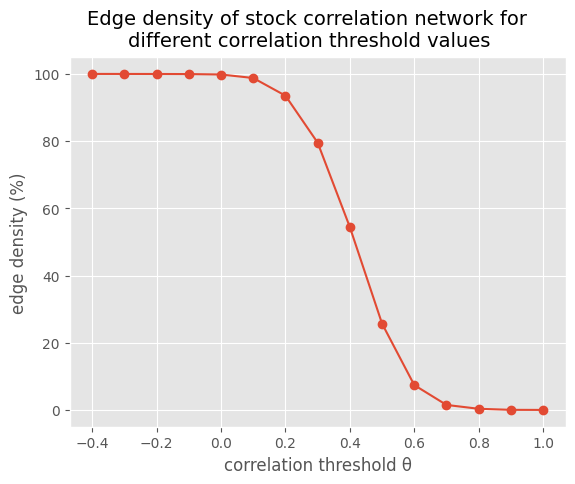

/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/4174391557.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prob_corr['cumulative_prob'].iloc[0] = prob_corr['probability'].iloc[0]
/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/4174391557.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prob_corr['cumulative_prob'].iloc[i+1] = prob_corr['probability'].iloc[i+1] + prob_corr['cumulative_prob'].iloc[i]
/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/4174391557.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

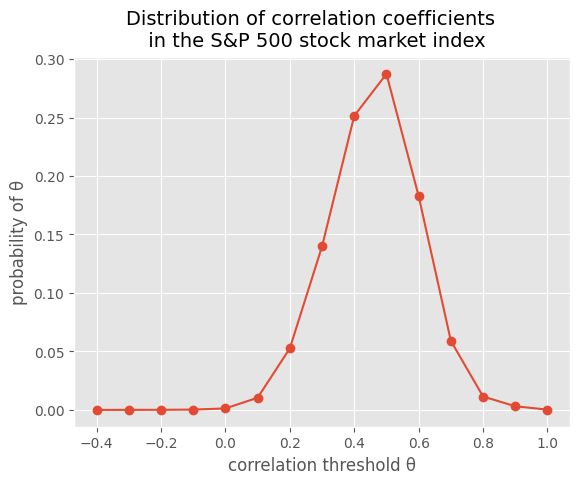

In [22]:
def count_network_edges(df):
    
    '''Counts number of edges in the network for different corrleation threshold values, plots edge density
    and correlation distributions'''
    
    thresholds = [-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    num_edges = pd.DataFrame()
    
    corr_matrix = df.corr()
    
    # Create table of number of edges
    for value in thresholds:
        adj_matrix = np.where(corr_matrix > value, 1, 0)
        np.fill_diagonal(adj_matrix, 0)
        adj_matrix = pd.DataFrame(adj_matrix, columns=df.columns, index=df.columns)
        
        link_triangle = adj_matrix.where(np.triu(np.ones(adj_matrix.shape)).astype(bool))
        link_triangle.fillna(0, inplace=True)
        
        sum_edges = link_triangle[link_triangle==1].count().sum()
        num_edges[value] = [sum_edges]
    
    np.fill_diagonal(corr_matrix.values, np.nan)
    corr_triangle = np.array(corr_log_return.where(np.triu(np.ones(corr_log_return.shape)).astype(bool)))
    total_edges = np.count_nonzero(~np.isnan(corr_triangle))
    
    num_edges.rename(index ={0:'num_edges'}, inplace=True)
    num_edges = num_edges.T
    num_edges['difference'] = num_edges['num_edges'].shift()-num_edges['num_edges']
    num_edges['edge_density (%)'] = round((num_edges['num_edges']/total_edges)*100, 4)
    num_edges.fillna(0, inplace=True)
    num_edges.index.name = 'corr_threshold'
    
    # Plot edge density
    plt.plot(np.array(num_edges.index), num_edges['edge_density (%)'].values, '-o')
    plt.xlabel('correlation threshold θ')
    plt.ylabel('edge density (%)')
    plt.suptitle('Edge density of stock correlation network for \ndifferent correlation threshold values', fontsize=14)
    plt.savefig('Images/edge_density_plot.png')
    plt.show()
    plt.close()
    
    # Create table of probability density
    all_probs = [0]
    
    for i in range(len(thresholds)):
        if thresholds[i] == thresholds[-1]:
            break
        over_thres = corr_triangle[np.where((corr_triangle >= thresholds[i]) & (corr_triangle < thresholds[i+1]))]
        count = len(over_thres)
        all_probs.append(count)
        
    
    prob_corr = pd.DataFrame(all_probs, columns=['count'], index=thresholds)
    prob_corr['probability'] = prob_corr['count']/total_edges
    prob_corr['cumulative_prob'] = ''
    prob_corr['cumulative_prob'].iloc[0] = prob_corr['probability'].iloc[0]
    prob_corr['cumulative_prob'] = pd.to_numeric(prob_corr['cumulative_prob'], errors='coerce')
    
    for i in range(len(prob_corr)):
        if i+1 != len(prob_corr):
            prob_corr['cumulative_prob'].iloc[i+1] = prob_corr['probability'].iloc[i+1] + prob_corr['cumulative_prob'].iloc[i]
   
    prob_corr['cumulative_prob'] = 1 - prob_corr['cumulative_prob']
    prob_corr.index.name = 'corr_threshold'

    
    # Plot probability distribution
    plt.plot(np.array(prob_corr.index), prob_corr['probability'].values, '-o')
    plt.xlabel('correlation threshold θ')
    plt.ylabel('probability of θ')
    plt.suptitle('Distribution of correlation coefficients \n in the S&P 500 stock market index', fontsize=14)
    plt.savefig('Images/corr_coeff_distr.png')
    plt.show()
    plt.close()
               
    
    return num_edges, prob_corr


# Implementation
num_logret_edges, prob_logret_corr = count_network_edges(log_return_500)

In [23]:
# Inspect dataframe
num_logret_edges

,num_edges,difference,edge_density (%)
corr_threshold,,,
-0.4,123746,0.0,99.9943
-0.3,123738,8.0,99.9879
-0.2,123725,13.0,99.9774
-0.1,123691,34.0,99.9499
0.0,123532,159.0,99.8214
0.1,122243,1289.0,98.7798
0.2,115732,6511.0,93.5185
0.3,98433,17299.0,79.5399
0.4,67320,31113.0,54.3987


In [24]:
# Inspect dataframe
prob_logret_corr

,count,probability,cumulative_prob
corr_threshold,,,
-0.4,0,0.000000,1.000000
-0.3,8,0.000065,0.999935
-0.2,13,0.000105,0.999830
-0.1,34,0.000275,0.999556
0.0,159,0.001285,0.998271
0.1,1289,0.010416,0.987855
0.2,6511,0.052613,0.935242
0.3,17299,0.139787,0.795455
0.4,31113,0.251412,0.544043


/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/637356352.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xl, yl, '-r', color='b')


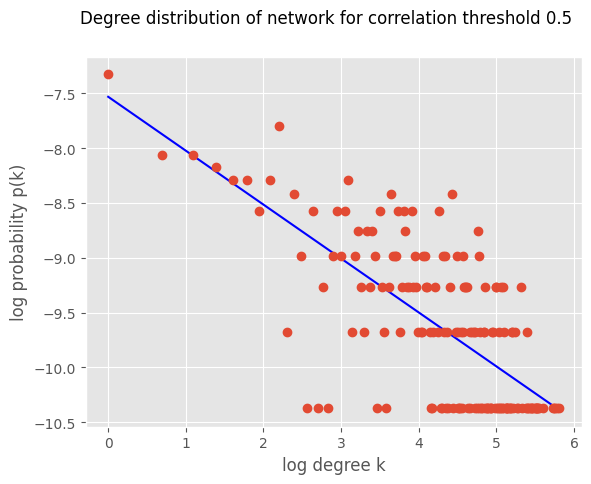

Number of nodes: 465 
Number of edges: 31770


/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/637356352.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xl, yl, '-r', color='b')


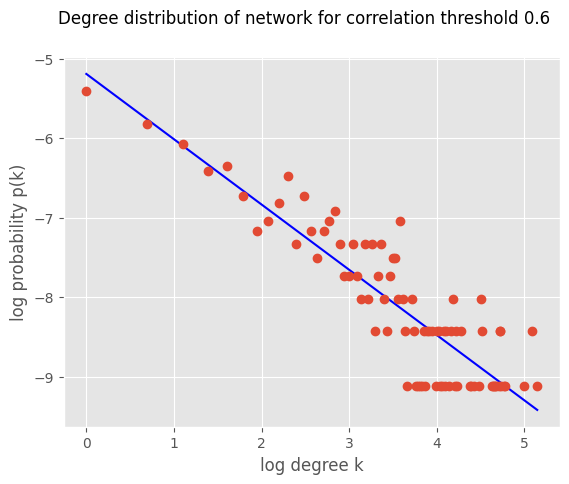

Number of nodes: 381 
Number of edges: 9145


/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/637356352.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xl, yl, '-r', color='b')


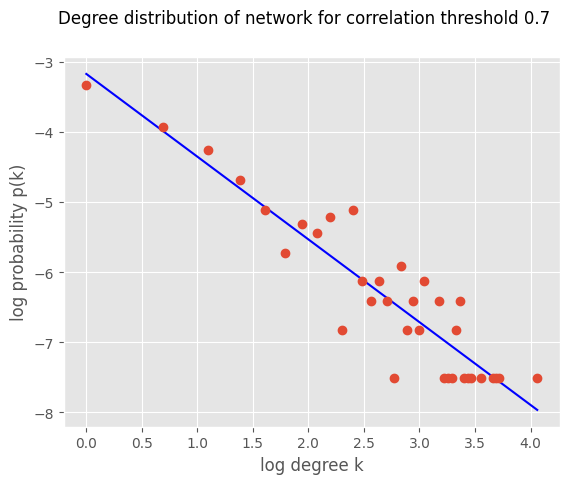

Number of nodes: 252 
Number of edges: 1838


/var/folders/j7/152m7hqd3pg_1qx71y_nsnk80000gn/T/ipykernel_17888/637356352.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.
  plt.plot(xl, yl, '-r', color='b')


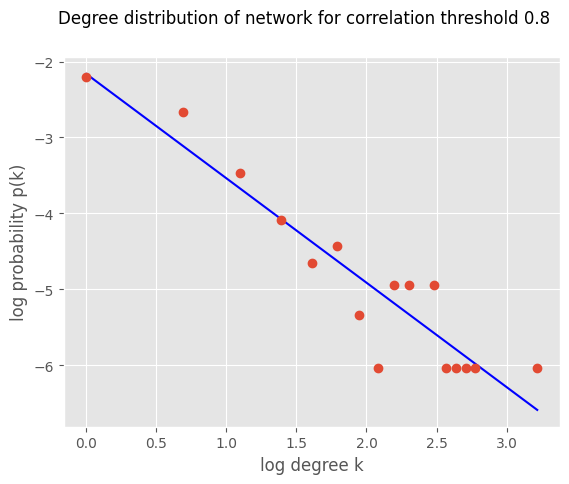

Number of nodes: 121 
Number of edges: 419


In [25]:
thres_list = [0.5, 0.6, 0.7, 0.8]

def graph_degree_distributions(df, thres_list):
    
    '''Graphs the log degree distributions of stock correlations above different correlation thresholds
    and finds the one that best follows the power law (shows a scale-free network)'''
    
    corr_matrix = df.corr()
    
    for threshold in thres_list:
        over_threshold = np.where(corr_matrix > threshold, 1, 0)
        np.fill_diagonal(over_threshold, 0)
        adj_matrix = pd.DataFrame(over_threshold, columns=corr_matrix.columns, index=corr_matrix.columns)

        links = adj_matrix.where(np.triu(np.ones(adj_matrix.shape)).astype(bool))
        links = links.stack().reset_index()
        links.columns = ['stock1', 'stock2','value']
        links['value'] = links['value'].astype(int)

        links_filtered = links.loc[(links['value'] == 1) & (links['stock1'] != links['stock2'])]
        link_list = links_filtered[links_filtered['value']==1].groupby('stock1').size()
        
        df_edges = pd.DataFrame(link_list, columns=['num_edges'])
        df_edges.index.name = 'stock'
        sum_edges = df_edges['num_edges'].sum()
        sum_nodes = len(links_filtered.groupby('stock1').size())
    
        edge_freq = df_edges.groupby('num_edges').size()
        df_degree = pd.DataFrame(edge_freq, columns=['frequency'])
        df_degree['degree_prob'] = df_degree['frequency']/sum_edges
        df_degree
        
        # Plot best-fit line
        par = np.polyfit(np.log(df_degree.index), np.log(df_degree['degree_prob']), 1, full=True)
        slope = par[0][0]
        intercept = par[0][1]
        xl = [min(np.log(df_degree.index)), max(np.log(df_degree.index))]
        yl = [slope*xx + intercept  for xx in xl]

        plt.plot(xl, yl, '-r', color='b')
        
        # Plot scatter points
        plt.plot(np.array(np.log(df_degree.index)), np.log(df_degree['degree_prob'].values), 'o')
        plt.xlabel('log degree k')
        plt.ylabel('log probability p(k)')
        plt.suptitle('Degree distribution of network for correlation threshold '+str(threshold))
        plt.savefig('Images/degree_distr_'+str(threshold)+'.png')
        plt.show()
        plt.close()
        print('Number of nodes:', len(df_edges), '\nNumber of edges:', sum_edges)
    
    return


# Implementation
graph_degree_distributions(log_return_500, thres_list)

In [42]:
def build_correlation_matrices(df, threshold):
    
    '''Creates correlation matrices for each quater and the corresponding adjacency matrices with 
    1=high correlation and 0=low correlation, both stored in lists'''
    
    corr_20_quarters, adj_20_quarters = [], []
    
    for quarter in df.values():
        corr_matrix = quarter.corr()
        corr_20_quarters.append(corr_matrix)   
        
        over_threshold = np.where(corr_matrix > threshold, 1, 0)
        np.fill_diagonal(over_threshold, 0)
        over_threshold = pd.DataFrame(over_threshold, columns=corr_matrix.columns, index=corr_matrix.columns)
        adj_20_quarters.append(over_threshold)

    return corr_20_quarters, adj_20_quarters

threshold = 0.65

corr_logret_quarters, adj_logret_quaters = build_correlation_matrices(logret_quarter_splits, threshold)

print(len(corr_logret_quarters), len(adj_logret_quaters))
corr_logret_quarters[0]

20 20


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.509370,0.376548,0.653247,0.506273,0.411827,0.740452,0.415462,0.733292,0.745504,...,0.121154,0.208371,0.510005,0.382700,0.683660,0.678501,0.723792,0.339950,0.714807,0.771568
AAL,0.509370,1.000000,0.291554,0.688346,0.286189,0.357260,0.344990,0.373955,0.561620,0.630805,...,0.184483,0.029968,0.389008,0.255361,0.415285,0.480753,0.389789,0.391894,0.601318,0.417187
AAP,0.376548,0.291554,1.000000,0.314704,0.286056,0.162430,0.297501,0.237686,0.355023,0.344948,...,0.027202,-0.002426,0.366339,0.229661,0.301609,0.343770,0.280229,0.182509,0.432156,0.369748
AAPL,0.653247,0.688346,0.314704,1.000000,0.268598,0.347434,0.537426,0.228360,0.658636,0.768478,...,0.150358,0.181926,0.517457,0.343871,0.438058,0.544388,0.483823,0.351441,0.556461,0.631505
ABBV,0.506273,0.286189,0.286056,0.268598,1.000000,0.500466,0.467682,0.300146,0.596026,0.388743,...,-0.024183,-0.018320,0.364339,0.313990,0.530125,0.352822,0.478429,0.233958,0.503374,0.522030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.678501,0.480753,0.343770,0.544388,0.352822,0.289011,0.651969,0.448712,0.592318,0.631946,...,0.155661,0.250844,0.474905,0.331203,0.476039,1.000000,0.597267,0.327476,0.570845,0.597841
ZBH,0.723792,0.389789,0.280229,0.483823,0.478429,0.423649,0.700203,0.521428,0.635879,0.636206,...,0.117744,0.198906,0.495161,0.461005,0.662362,0.597267,1.000000,0.177064,0.689939,0.652657
ZBRA,0.339950,0.391894,0.182509,0.351441,0.233958,0.212440,0.290901,0.226626,0.388511,0.430749,...,0.019183,0.098354,0.406270,0.129117,0.296351,0.327476,0.177064,1.000000,0.331474,0.421148
ZION,0.714807,0.601318,0.432156,0.556461,0.503374,0.416267,0.643003,0.619203,0.687410,0.664616,...,0.200142,-0.000185,0.464672,0.328882,0.672822,0.570845,0.689939,0.331474,1.000000,0.634319


In [37]:
adj_logret_quaters[0]

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,0,0,0,1,0,0,1,0,1,1,...,0,0,0,0,1,1,1,0,1,1
AAL,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
AAP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAPL,1,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
ABBV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ZBH,1,0,0,0,0,0,1,0,1,1,...,0,0,0,0,1,0,0,0,1,1
ZBRA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZION,1,1,0,0,0,0,1,1,1,1,...,0,0,0,0,1,0,1,0,0,1


In [40]:
print(len(adj_logret_quaters))

20


In [44]:
def write_csv_files(matrix_list, measure):
    
    '''Save adjacency matrices as csv files in directory'''

    for i, matrix in enumerate(matrix_list):
        matrix.to_csv('Quarters_Adj_Matrices/' + 'Q'+str(i+1)+'_'+measure+'.csv')
    
    return


# This will save the log return adj_matrices DataFrames as CSV files in the format "key_logret.csv",
#  where key is the key from the logret_quarter_adj_matrix dictionary.

_, adj_volume_quaters = build_correlation_matrices(logret_quarter_splits, threshold)
_, adj_return_quaters = build_correlation_matrices(logret_quarter_splits, threshold)
_, adj_marketcap_quaters = build_correlation_matrices(logret_quarter_splits, threshold)

write_csv_files(adj_logret_quaters, 'logret')
write_csv_files(adj_volume_quaters, 'volume')
write_csv_files(adj_return_quaters, 'return')
write_csv_files(adj_marketcap_quaters, 'marketcap')

# Hierarchical Clustering

In [29]:
print(logret_quarter_splits.keys())


dict_keys(['2018_Q1', '2018_Q2', '2018_Q3', '2018_Q4', '2019_Q1', '2019_Q2', '2019_Q3', '2019_Q4', '2020_Q1', '2020_Q2', '2020_Q3', '2020_Q4', '2021_Q1', '2021_Q2', '2021_Q3', '2021_Q4', '2022_Q1', '2022_Q2', '2022_Q3', '2022_Q4'])


In [30]:
# Choose a specific key from the logret_quarter_splits dictionary
key = "2018_Q3"

# Calculate the correlation matrix for the selected key
corr_matrix = logret_quarter_splits[key].corr()

# Drop rows and columns with all NaN values
corr_matrix.dropna(axis=1, how='all', inplace=True)
corr_matrix.dropna(axis=0, how='all', inplace=True)

corr_matrix.head()


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.285345,0.162665,0.078866,0.090983,0.233797,0.278745,0.236797,0.399923,0.348803,...,0.342243,0.059280,0.374939,-0.023638,0.449871,0.260259,0.008810,0.324638,-0.116729,0.362078
AAL,0.285345,1.000000,0.246129,-0.029846,0.087075,0.135051,0.139481,0.444557,0.144637,0.094527,...,0.355965,-0.038439,0.204960,0.105267,0.334111,0.322443,-0.005424,0.111706,0.240430,0.261587
AAP,0.162665,0.246129,1.000000,0.119987,-0.171740,0.183620,0.008560,0.194573,0.292600,0.204046,...,-0.066087,-0.110722,-0.055804,0.023220,-0.003776,0.387625,-0.156835,0.072380,0.350544,0.236809
AAPL,0.078866,-0.029846,0.119987,1.000000,0.408888,-0.176195,0.161380,0.029936,0.322921,0.296016,...,-0.074098,-0.042205,-0.037816,0.121962,-0.081323,0.228552,-0.082817,0.099066,0.200780,0.315085
ABBV,0.090983,0.087075,-0.171740,0.408888,1.000000,0.143906,0.339168,0.184106,0.095764,0.139321,...,0.104873,0.136043,0.171292,0.242520,0.112013,0.110161,0.016974,-0.042456,-0.112879,0.206752


In [31]:
# Compute distance matrix from correlation matrix
dist_matrix = np.sqrt(2*(1-corr_matrix))
dist_matrix

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,0.000000,1.195538,1.294091,1.357302,1.348345,1.237904,1.201045,1.235478,1.095515,1.141225,...,1.146959,1.371656,1.118089,1.430831,1.048932,1.216339,1.407970,1.162206,1.494476,1.129532
AAL,1.195538,0.000000,1.227902,1.435163,1.351240,1.315256,1.311883,1.053985,1.307947,1.345714,...,1.134932,1.441138,1.260984,1.337709,1.154027,1.164093,1.418043,1.332887,1.232534,1.215247
AAP,1.294091,1.227902,0.000000,1.326659,1.530843,1.277795,1.408148,1.269194,1.189453,1.261708,...,1.460197,1.490451,1.453137,1.397698,1.416881,1.106684,1.521075,1.362072,1.139698,1.235469
AAPL,1.357302,1.435163,1.326659,0.000000,1.087301,1.533750,1.295083,1.392884,1.163683,1.186578,...,1.465672,1.443749,1.440705,1.325170,1.470593,1.242134,1.471609,1.342337,1.264294,1.170398
ABBV,1.348345,1.351240,1.530843,1.087301,0.000000,1.308506,1.149637,1.277414,1.344794,1.312005,...,1.338004,1.314501,1.287407,1.230837,1.332657,1.334045,1.402159,1.443922,1.491897,1.259562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,1.216339,1.164093,1.106684,1.242134,1.334045,1.321381,1.248277,1.278796,1.168106,1.206672,...,1.447918,1.436418,1.420698,1.341929,1.196223,0.000000,1.407368,1.370320,1.194171,0.950840
ZBH,1.407970,1.418043,1.521075,1.471609,1.402159,1.292243,1.301149,1.311069,1.473851,1.478967,...,1.386075,1.433105,1.525738,1.269880,1.395953,1.407368,0.000000,1.482868,1.527480,1.372107
ZBRA,1.162206,1.332887,1.362072,1.342337,1.443922,1.278247,1.406646,1.375231,1.244155,1.202936,...,1.404619,1.423395,1.244244,1.853075,1.312724,1.370320,1.482868,0.000000,1.379395,1.280287
ZION,1.494476,1.232534,1.139698,1.264294,1.491897,1.482757,1.472379,1.297539,1.320720,1.400989,...,1.434979,1.617556,1.447023,1.466155,1.527732,1.194171,1.527480,1.379395,0.000000,1.397423


In [32]:
# Convert distance matrix into an array using only the upper triangle values
dist_array = np.array(dist_matrix)
dist_array_upper = np.triu(dist_array, k=1)
dist_array_upper

array([[0.        , 1.19553753, 1.29409065, ..., 1.16220644, 1.49447572,
        1.12953224],
       [0.        , 0.        , 1.22790166, ..., 1.3328874 , 1.23253397,
        1.21524746],
       [0.        , 0.        , 0.        , ..., 1.36207201, 1.13969806,
        1.23546851],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.37939543,
        1.28028722],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.39742311],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

488
[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  1  1  1  2  1  1  1  1  1  1  1  1  1  2  2  1  2  1
  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  6  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  3  3  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7 11 11 11 11 11 11 11 11 11 11 11 11 11 1

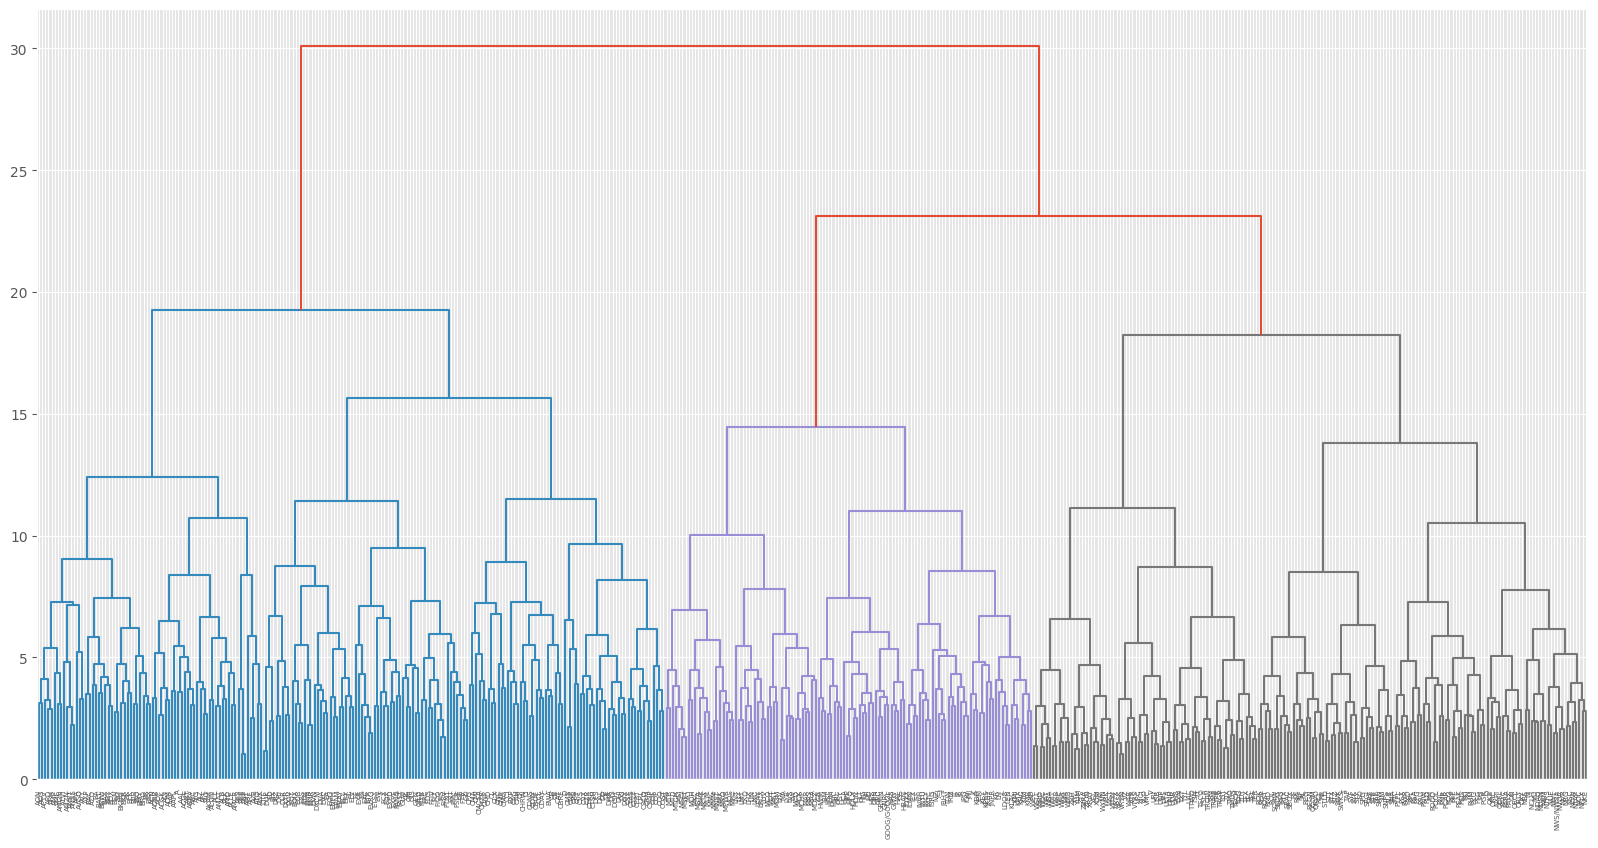

array([ 37,  38,  42,  40,  41,  32,  30,  31,  45,  34,  35,  36,  39,
        47,  48,  50,  53,  51,  52,  54,  56,  55,  57,  58,  59,  60,
        64,  65,  63,  66,  61,  62,  67,  69,  68,  70,   8,   9,  12,
        13,  10,  11,   2,   3,   0,   1,   7,   6,   4,   5,  20,  19,
        17,  18,  21,  23,  25,  27,  22,  24,  29,  26,  28,  16,  14,
        15,  33,  43,  46,  44,  49, 138, 139, 147, 149, 136, 137, 133,
       134, 135, 159, 157, 158, 161, 162, 152, 153, 141, 143, 140, 142,
       144, 155, 154, 156, 145, 146, 148, 150, 151, 177, 170, 160, 167,
       163, 165, 164, 166, 171, 174, 176, 168, 169, 172, 173, 196, 195,
       197, 194, 192, 193, 182, 185, 175, 178, 183, 179, 180, 181, 188,
       186, 184, 187, 191, 189, 190,  87,  95,  99,  96,  90,  92,  88,
        93,  94, 101,  97,  98,  80,  72,  74,  75,  86,  89,  91,  83,
        84,  78,  81,  82,  73,  71,  77,  85,  76,  79, 122, 100, 102,
       107, 109, 119, 120, 121, 117, 118, 126, 123, 124, 125, 13

In [33]:
# Visualize dendrogram of hierarchical clustering and divide into 11 clusters
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, leaves_list

Z = linkage(dist_array_upper, method='complete', metric='euclidean')
print(len(Z))

labels = dist_matrix.index

fl = fcluster(Z, 11, criterion='maxclust')
print(fl)

fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z, labels=labels)
plt.show()

leaves_list(Z)

In [34]:
# Show company names in labels list
labels[leaves_list(Z)]

Index(['AON', 'AOS', 'APTV', 'APD', 'APH', 'AMP', 'AME', 'AMGN', 'ATVI',
       'AMZN',
       ...
       'NWS/NWSA', 'NVDA', 'NVR', 'NRG', 'NSC', 'NOW', 'NTAP', 'NOC', 'NFLX',
       'NKE'],
      dtype='object', length=489)

In [36]:
# TODO: Get company sectors and continue HC
'''
# Make dataframe sectors into a dictionary
sectors = pd.read_csv('company_sectors.csv')
sectors.set_index('Company', inplace=True)
sector_dict = sectors['Sector'].to_dict()
sector_dict
'''

"\n# Make dataframe sectors into a dictionary\nsectors = pd.read_csv('company_sectors.csv')\nsectors.set_index('Company', inplace=True)\nsector_dict = sectors['Sector'].to_dict()\nsector_dict\n"